In [38]:
import numpy as np
from scipy.linalg import eig, eigh
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigsh as speigsh
from scipy.sparse.linalg import eigs as speigs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib import animation
from matplotlib.colors import Normalize

# Utility & Logging
import os
import time
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm
import warnings

In [39]:
np.random.seed(42)

DATA_PATH = 'data/ex3'
MEDIA_PATH = 'media/ex3'
LOG_PATH = 'log'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MEDIA_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

LOAD_CACHED_FILES_IF_AVAILABLE = True

log = Logger('Set 3 Logger')
fh = FileHandler(f'{LOG_PATH}/ex3_1.log', mode='w', level=DEBUG, bubble=True)
fh.push_application()
warnings.filterwarnings('ignore')

Function to generate five-point stencil to discretize Laplacian

In [46]:
def fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, radius=None, sparse=False):
    '''
    Creates a five-point stencil finite difference matrix M to approximate the Laplacian operator in eigenvalue problem.
    Excludes the boundary points as they are stationary.

    Args:
        nx (int): Number of grid points in the x direction.
        ny (int): Number of grid points in the y direction.
        radius (float): Radius of the circular mask in the original spatial dimensions.

    Returns:
        np.ndarray: The five-point stencil finite difference matrix M for the inner points.
    '''
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    nx, ny = Nx - 2, Ny - 2
    N = nx * ny  # Excluding boundary points
    if sparse:
        M = lil_matrix((N, N))
    else:
        M = np.zeros((N, N))

    circle_mask = None
    if radius is not None:
        # Create mask for the circular region
        circle_mask = np.zeros((nx, ny))
        x, y = np.meshgrid(np.linspace(-Lx/2, Lx/2, nx), np.linspace(-Ly/2, Ly/2, ny))
        circle_mask = np.where(x**2 + y**2 <= radius**2, 0, 1)

    for x in range(nx):
        for y in range(ny):
            if circle_mask is not None and circle_mask[x, y]:
                continue

            index = x * ny + y
            M[index, index] = -2 / dx**2 - 2 / dy**2

            if x > 0:
                M[index, index - ny] = 1 / dx**2
            if x < nx - 1:
                M[index, index + ny] = 1 / dx**2

            if y > 0:
                M[index, index - 1] = 1 / dy**2
            if y < ny - 1:
                M[index, index + 1] = 1 / dy**2

    if sparse:
        M = M.tocsr()
    return M

def vis_fd_matrix(M, Nx, Ny):
    fig = plt.figure(figsize=(4, 4), layout='tight')
    nx, ny = Nx-2, Ny-2
    N = nx * ny
    plt.imshow(M, cmap='viridis')
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if i == j:
                color = 'white'
            else:
                color = 'black'
            plt.text(j, i, int(M[i, j]),
                    ha="center", va="center", color=color, fontsize=8)
    plt.title('Finite difference matrix $M$')
    plt.xlabel('Column index')
    plt.ylabel('Row index')
    plt.savefig(f'{MEDIA_PATH}/fd_matrix_{Nx}x{Ny}.png', dpi=300, bbox_inches='tight')
    return fig
    
def size_in_bytes(M):
    '''
    Returns the size of the matrix M in bytes.
    '''
    if isinstance(M, np.ndarray):
        return M.nbytes
    elif hasattr(M, 'data'):
        return M.data.nbytes + M.indptr.nbytes + M.indices.nbytes
    else:
        raise NotImplementedError('Unknown matrix type')

    
def add_boundary_to_eigvec(eigvec, nx, ny):
    '''
    Adds the edges back to the eigenvector eigvec.
    '''
    log.debug('Adding boundary to eigenvector.')
    Nx, Ny = nx + 2, ny + 2
    eigvec_full = np.zeros((Nx, Ny))
    eigvec_full[1:-1, 1:-1] = eigvec.reshape(nx, ny)
    return eigvec_full

def solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=None, sort_order='ascending', sparse=False, k=3, which='largest'):
    '''
    Solves the eigenvalue problem Mv = Kv for the matrix M, here a finite difference approximation of the Laplacian operator.

    Args:
        Nx (int): Number of discretization points in x.
        Ny (int): Number of discretization points in y.
        sort_order (str): The order in which to sort returned values, either `ascending` or `descending`.
        sparse (bool): Whether to use sparse mode.
        sparse_k (int): The number of eigenvalues to compute.
        sparse_which (str): Which eigenvalues to compute.

    Returns:
        np.ndarray: The finite difference matrix M.
        np.ndarray: The eigenvalues K.
        np.ndarray: The eigenvectors v.
        np.ndarray: The eigenfrequencies f.
    '''
    nx, ny = Nx-2, Ny-2
    N = nx * ny

    M = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=sparse, radius=radius)
    log.info(f'Solving eigenvector problem Mv = Kv for the finite difference matrix M of size ({M.shape[0]},{M.shape[1]}).')

    if sparse:
        if k is None:
            log.error('sparse_k should be provided if sparse is True. Using N-2 as default, but this may be slow.')
            k = N-2
        if which is None:
            log.error('sparse_which should be provided if sparse is True. Using "LE" as default, but this may not be the intended result.')
            which = 'LE'
        eigvals, eigvecs = speigs(M, k=k, which=which)
    else:
        if check_symmetric(M):
            log.info('Matrix is symmetric. Using linalg.eigh.')
            eigvals, eigvecs = eigh(M)
        else:
            log.info('Matrix is not symmetric. Using linalg.eig.')
            eigvals, eigvecs = eig(M)

    log.info(f'Sorting eigenvalues and vectors in {sort_order} order.')
    
    if sort_order == 'ascending':
        sort_indices = np.argsort(eigvals)
    elif sort_order == 'descending':
        sort_indices = np.argsort(-eigvals)
    else:
        raise ValueError('sort_order must be "ascending" or "descending"')
    
    eigvals, eigvecs = eigvals[sort_indices], eigvecs[:, sort_indices]
    eigfreqs = np.real(np.sqrt(-eigvals)) # ignore imaginary component
    
    return M, eigvals, eigvecs, eigfreqs

def vis_eigvecs(eigvecs, eigvals, eigfreqs, Nx, Ny, plot_shape=(1, 3)):
    plx, ply = plot_shape
    plratio = Nx/Ny
    nx, ny = Nx-2, Ny-2
    fig, axs = plt.subplots(plx, ply, figsize=(10, 4/plratio), constrained_layout=True)
    images = []
    
    vmin = np.min(eigvecs[:, :len(axs.flatten())])
    vmax = np.max(eigvecs[:, :len(axs.flatten())])
    max_v = max(abs(vmin), abs(vmax))
    norm = Normalize(vmin=-max_v, vmax=max_v)

    for i, ax in enumerate(axs.flatten()):
        eigvec, eigval, eigfreq = eigvecs[:, i], eigvals[i], eigfreqs[i]
        eigvec = np.rot90(add_boundary_to_eigvec(eigvec, nx, ny).reshape(Nx, Ny))
        im = ax.imshow(eigvec, origin='lower', norm=norm, cmap='terrain')
        images.append(im)
        if plratio < 1:
            ax.set_title(f'$\\lambda_{i+1}={float(eigval):.2f}$\n$f_{i+1}={int(eigfreq)} Hz$')
        else:
            ax.set_title(f'$\\lambda_{i+1}={float(eigval):.2f}$, $f_{i+1}={int(eigfreq)} Hz$')
        ax.axis('off')

    fig.colorbar(images[0], ax=axs.ravel().tolist(), orientation='horizontal', label='Amplitude', norm=norm, shrink=0.6, cmap='terrain')

    return fig

def time_dependent_solution(eigvec, eigfreq, t):
    return eigvec * np.cos(eigfreq * t)

def vis_eigvecs_animate(eigvecs, eigvals, eigfreqs, Nx, Ny, plot_shape=(1, 3), duration=5, fps=20):
    plx, ply = plot_shape
    plratio = Nx/Ny
    nx, ny = Nx-2, Ny-2
    fig, axs = plt.subplots(plx, ply, figsize=(10, 4/plratio), constrained_layout=True)
    images = []
    
    vmin = np.min(eigvecs[:, :len(axs.flatten())])
    vmax = np.max(eigvecs[:, :len(axs.flatten())])
    max_v = max(abs(vmin), abs(vmax))
    norm = Normalize(vmin=-max_v, vmax=max_v)

    # Create a dummy image for the colorbar
    dummy_image = plt.imshow(np.zeros((Nx, Ny)), origin='lower', norm=norm, cmap='terrain')
    fig.colorbar(dummy_image, ax=axs.ravel().tolist(), orientation='horizontal', label='Amplitude', shrink=0.6)
    plt.close(dummy_image.figure)

    def update(i):
        t = i / fps  # convert frame number to time (s)
        for ax in axs.flatten():
            ax.clear()
        for i, ax in enumerate(axs.flatten()):
            eigvec, eigval, eigfreq = eigvecs[:, i], eigvals[i], eigfreqs[i]
            eigvec = np.rot90(add_boundary_to_eigvec(eigvec, nx, ny).reshape(Nx, Ny))
            u = time_dependent_solution(eigvec, eigfreq, t)
            im = ax.imshow(u, origin='lower', norm=norm, cmap='terrain')
            images.append(im)
            if plratio < 1:
                ax.set_title(f'$\\lambda_{i+1}={float(eigval):.2f}$\n$f_{i+1}={int(eigfreq)} Hz$')
            else:
                ax.set_title(f'$\\lambda_{i+1}={float(eigval):.2f}$, $f_{i+1}={int(eigfreq)} Hz$')
            ax.axis('off')

    ani = animation.FuncAnimation(fig, update, frames=duration*fps, interval=1000/fps)
    return ani

def check_symmetric(A, rtol=1e-05, atol=1e-08):
    if isinstance(A, np.ndarray):
        return np.allclose(A, A.T, rtol=rtol, atol=atol)
    elif hasattr(A, 'toarray'):
        return np.allclose(A.toarray(), A.toarray().T, rtol=rtol, atol=atol)
    else:
        raise NotImplementedError('Unknown matrix type')

Comparison of memory requirements for matrix types and visualization of matrix $M$

Size in memory (dense): 128 bytes
Size in memory (sparse): 164 bytes


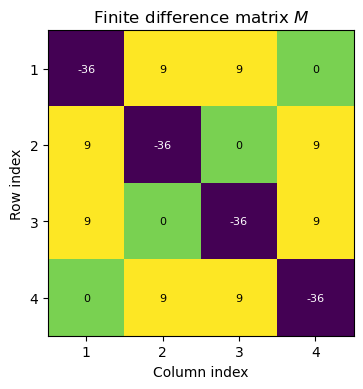

In [41]:
Nx, Ny = 4, 4
nx, ny = Nx-2, Ny-2
N = nx * ny
Lx, Ly = 1, 1

M_inner = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=False)
print(f'Size in memory (dense): {size_in_bytes(M_inner)} bytes')
Ms_inner = fd_laplacian_matrix_inner(Nx, Ny, Lx, Ly, sparse=True)
print(f'Size in memory (sparse): {size_in_bytes(Ms_inner)} bytes')

fig = vis_fd_matrix(M_inner, Nx, Ny)

Visualizing eigenmodes for dense and sparse matrix and square drum of size $L_x = L_y = 1$.

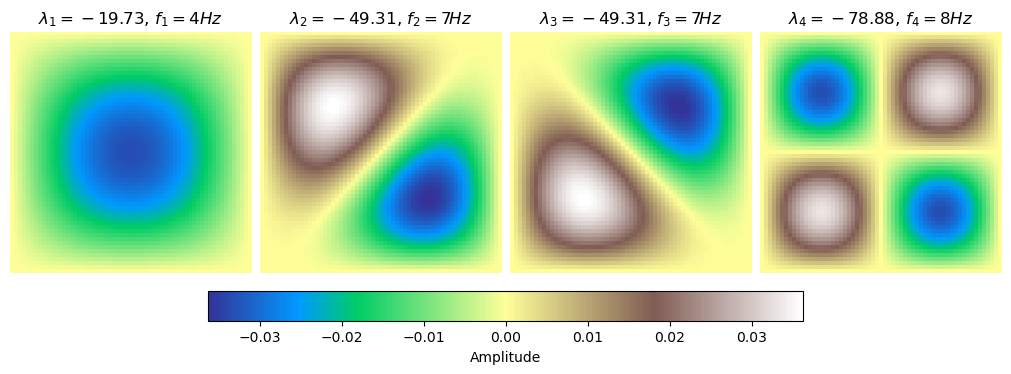

In [47]:
# Select only the edge cases we want to visualize
which_l = 'LM'
which_s = 'SM'
k = 4

# Parameters
Nx, Ny = 61, 61
Lx, Ly = 1, 1

M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, k=k, which=which_l)
M, eigvals_s, eigvecs_s, eigfreqs_s = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='descending', sparse=True, k=k, which=which_s)

ani = vis_eigvecs_animate(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, plot_shape=(1, k), duration=5, fps=30)
ani.save(f'{MEDIA_PATH}/animiation_eigvecs_square_{Nx}x{Ny}_L={Lx}x{Ly}_k={k}_which={which_s}.gif', writer=ANIM_BACKEND)
plt.close()

fig = vis_eigvecs(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, plot_shape=(1, k))
fig.savefig(f'{MEDIA_PATH}/eigvecs_square_{Nx}x{Ny}_L={Lx}x{Ly}_k={k}_which={which_s}.png', bbox_inches='tight')

Visualizing eigenmodes of a rectangular drum of size $L_x = 1$ and $L_y = 2$.

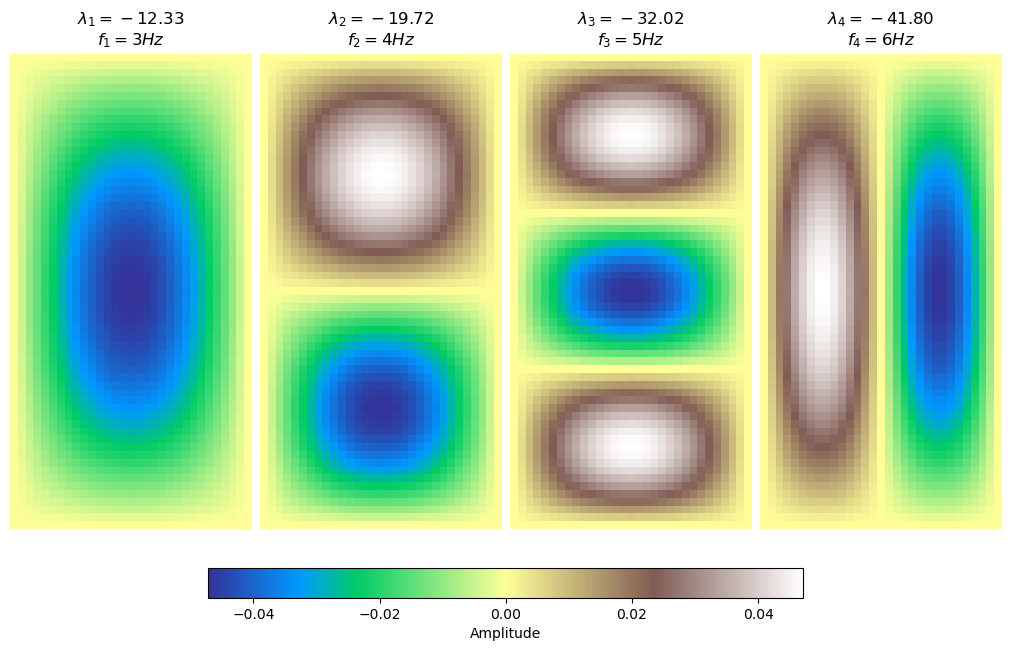

In [48]:
Nx, Ny = 31, 61
Lx, Ly = 1, 2

M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, k=k, which=which_l)
M, eigvals_s, eigvecs_s, eigfreqs_s = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='descending', sparse=True, k=k, which=which_s)

ani = vis_eigvecs_animate(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, plot_shape=(1, k), duration=5, fps=30)
ani.save(f'{MEDIA_PATH}/animiation_eigvecs_rectangle_{Nx}x{Ny}_L={Lx}x{Ly}_k={k}_which={which_s}.gif', writer=ANIM_BACKEND)
plt.close()

fig = vis_eigvecs(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, plot_shape=(1, k))
fig.savefig(f'{MEDIA_PATH}/eigvecs_rectangle_{Nx}x{Ny}_L={Lx}x{Ly}_k={k}_which={which_s}.png', bbox_inches='tight')

Visualizing eigenmodes of a circular drum of size $L_x = L_y = 1$ and radius $r = \frac{1}{2} L_x$.

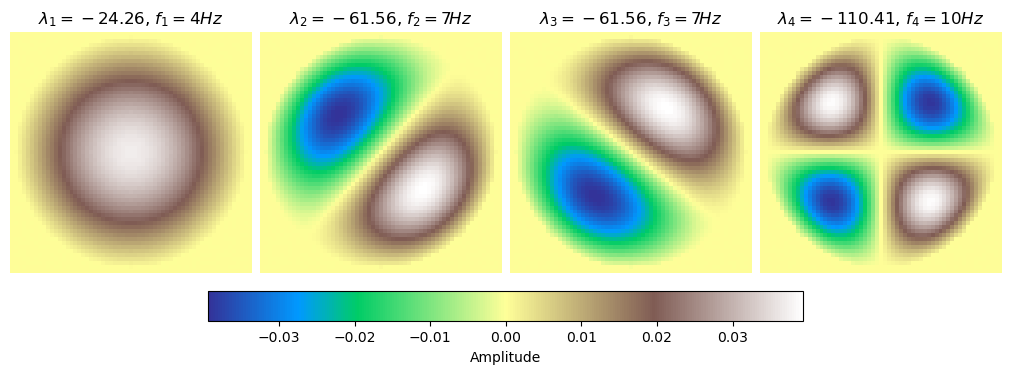

In [49]:
Nx, Ny = 61, 61
Lx, Ly = 1, 1
radius = 1/(2*Lx)

M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=radius, sort_order='ascending', sparse=True, k=k, which=which_l)
M, eigvals_s, eigvecs_s, eigfreqs_s = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=radius, sort_order='descending', sparse=True, k=300, which=which_s)
eigvals_s, eigvecs_s, eigfreqs_s = eigvals_s[eigfreqs_s > 0.1], eigvecs_s[:, eigfreqs_s > 0.1], eigfreqs_s[eigfreqs_s > 0.1]
eigvals_s, eigvecs_s, eigfreqs_s = eigvals_s[:k], eigvecs_s[:, :k], eigfreqs_s[:k]

ani = vis_eigvecs_animate(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, plot_shape=(1, k), duration=5, fps=30)
ani.save(f'{MEDIA_PATH}/animiation_eigvecs_circle_{Nx}x{Ny}_L={Lx}x{Ly}_radius={radius}_k={k}_which={which_s}.gif', writer=ANIM_BACKEND)
plt.close()

fig = vis_eigvecs(eigvecs_s, eigvals_s, eigfreqs_s, Nx, Ny, plot_shape=(1, k))
fig.savefig(f'{MEDIA_PATH}/eigvecs_circle_{Nx}x{Ny}_L={Lx}x{Ly}_radius={radius}_k={k}_which={which_s}.png', bbox_inches='tight')

Comparing time and memory performance of sparse vs. dense eigenvalue decomposition solvers

In [ ]:
N_range = np.arange(5, 41, 1)
ks = [1, 5, 25]
N_sim = 10

times_dense = np.zeros((len(N_range), len(ks)))
memory_dense = np.zeros((len(N_range), len(ks)))
times_sparse = np.zeros((len(N_range), len(ks)))
memory_sparse = np.zeros((len(N_range), len(ks)))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{DATA_PATH}/times_dense.npy'):
    times_dense = np.load(f'{DATA_PATH}/times_dense.npy')
    memory_dense = np.load(f'{DATA_PATH}/memory_dense.npy')
    times_sparse = np.load(f'{DATA_PATH}/times_sparse.npy')
    memory_sparse = np.load(f'{DATA_PATH}/memory_sparse.npy')
else:
    pbar = tqdm(total=len(N_range)*len(ks)*2, desc='Simulating across parameter space', unit='sim')
    for i, Nx in enumerate(N_range):
        for j, k in enumerate(ks):
            Ny = Nx
            N = (Nx-2)*(Ny-2)
            if k > N-2:
                times_dense[i, j], times_sparse[i, j] = np.nan, np.nan
                memory_dense[i, j], memory_sparse[i, j] = np.nan, np.nan
                pbar.update(2)
                continue

            time_dense = np.zeros((N_sim))
            for n in range(N_sim):
                start = time.time_ns()
                M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', k=k, which=which_l)
                end = time.time_ns()
                time_dense[n] = (end - start) / 1_000
            times_dense[i, j] = np.mean(time_dense)
            memory_dense[i, j] = size_in_bytes(M)
            pbar.update()

            time_sparse = np.zeros((N_sim))
            for n in range(N_sim):
                start = time.time_ns()
                M, eigvals_l, eigvecs_l, eigfreqs_l = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', sparse=True, k=k, which=which_l)
                end = time.time_ns()
                time_sparse[n] = (end - start) / 1_000

            times_sparse[i, j] = np.mean(time_sparse)
            memory_sparse[i, j] = size_in_bytes(M)
            pbar.update()
            
    np.save(f'{DATA_PATH}/times_dense.npy', times_dense)
    np.save(f'{DATA_PATH}/memory_dense.npy', memory_dense)
    np.save(f'{DATA_PATH}/times_sparse.npy', times_sparse)
    np.save(f'{DATA_PATH}/memory_sparse.npy', memory_sparse)

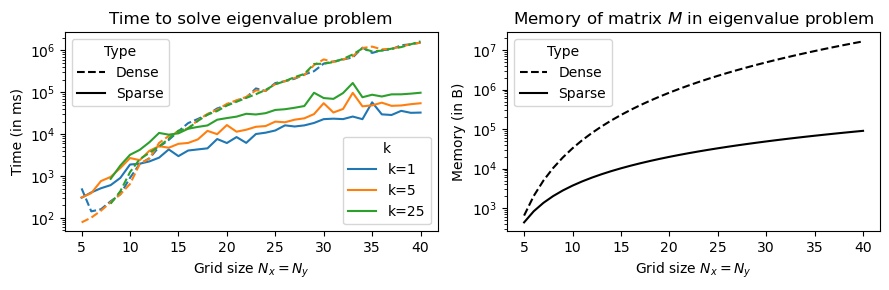

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
cmap = cm.get_cmap('viridis')
colors = ['tab:blue', 'tab:orange', 'tab:green']

ax = axs[0]
for i, k in enumerate(ks):
    color = colors[i]
    ax.plot(N_range, times_dense[:, i], linestyle='--', color=color)
    ax.plot(N_range, times_sparse[:, i], label=f'k={k}', linestyle='-', color=color)

ax.set_xlabel('Grid size $N_x=N_y$')
ax.set_ylabel('Time (in ms)')
ax.set_title('Time to solve eigenvalue problem')
ax.set_yscale('log')
first_legend = ax.legend(title='k', loc='lower right')
ax.add_artist(first_legend)
dense_line = mlines.Line2D([], [], color='black', linestyle='--', label='Dense')
sparse_line = mlines.Line2D([], [], color='black', linestyle='-', label='Sparse')
ax.legend(title='Type', handles=[dense_line, sparse_line], loc='upper left')

ax = axs[1]
ax.plot(N_range, memory_dense[:, 0], label=f'k={k}', linestyle='--', color='black')
ax.plot(N_range, memory_sparse[:, 0], label=f'k={k}', linestyle='-', color='black')
ax.set_xlabel('Grid size $N_x=N_y$')
ax.set_ylabel('Memory (in B)')
ax.set_title('Memory of matrix $M$ in eigenvalue problem')
ax.set_yscale('log')
dense_line = mlines.Line2D([], [], color='black', linestyle='--', label='Dense')
sparse_line = mlines.Line2D([], [], color='black', linestyle='-', label='Sparse')
ax.legend(title='Type', handles=[dense_line, sparse_line], loc='upper left')
plt.tight_layout()
plt.savefig(f'{MEDIA_PATH}/time_and_memory_comparison.png')

Visualizing effect of drum shapes, choice of spatial domain size $L$ and discretization $N_x$, $N_y$ on  eigenfrequency spectrums

In [ ]:
Ls = np.array([0.1, 0.5, 1.0, 5.0])
Nx, Ny = 21, 21
N = (Nx-2)*(Ny-2)
k = N

eigfreqs_square = np.zeros((len(Ls), N))

radii = Ls/2
eigfreqs_circle = np.zeros((len(Ls), N))

Nx_rect, Ny_rect = int(Nx/np.sqrt(2)), int(Ny*np.sqrt(2))
N_rect = (Nx_rect-2)*(Ny_rect-2)
k_rect = N_rect
eigfreqs_rectangle = np.zeros((len(Ls), N_rect))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{DATA_PATH}/eigfreqs_square.npy'):
    eigfreqs_square = np.load(f'{DATA_PATH}/eigfreqs_square.npy')
    eigfreqs_circle = np.load(f'{DATA_PATH}/eigfreqs_circle.npy')
    eigfreqs_rectangle = np.load(f'{DATA_PATH}/eigfreqs_rectangle.npy')
else:
    for i, (L, radius) in tqdm(enumerate(zip(Ls, radii))):
        Lx, Ly = L, L
        freqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, sort_order='ascending', k=k, which=which_l)[-1]
        eigfreqs_square[i, :] = freqs
        freqs = solve_eigenvalue_problem(Nx, Ny, Lx, Ly, radius=radius, sort_order='ascending', k=k, which=which_l)[-1]
        eigfreqs_circle[i, :] = freqs
        freqs = solve_eigenvalue_problem(int(Nx/np.sqrt(2)), int(Ny*np.sqrt(2)), Lx, Ly*2, sort_order='ascending', k=k_rect, which=which_l)[-1]
        eigfreqs_rectangle[i, :] = freqs
    np.save(f'{DATA_PATH}/eigfreqs_square.npy', eigfreqs_square)
    np.save(f'{DATA_PATH}/eigfreqs_circle.npy', eigfreqs_circle)
    np.save(f'{DATA_PATH}/eigfreqs_rectangle.npy', eigfreqs_rectangle)

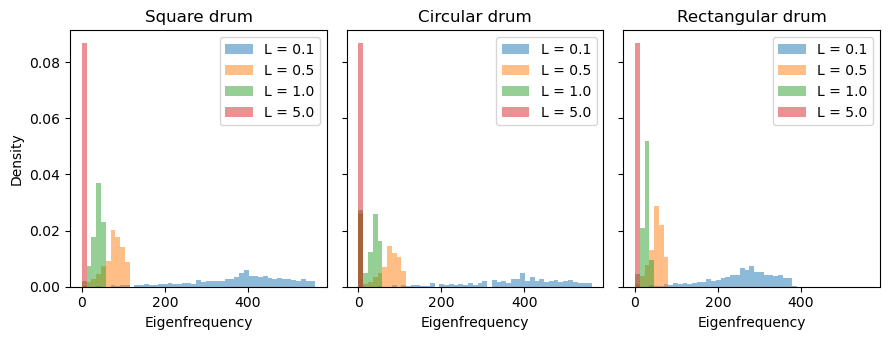

In [29]:
eigfreqs_list = [eigfreqs_square, eigfreqs_circle, eigfreqs_rectangle]
min_eigfreq = np.min([np.min(eigfreqs) for eigfreqs in eigfreqs_list])
max_eigfreq = np.max([np.max(eigfreqs) for eigfreqs in eigfreqs_list])
N_bins = 50
bin_edges = np.linspace(min_eigfreq, max_eigfreq, N_bins)

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5), layout='tight', sharey=True)
# fig.suptitle('Eigenfrequency distribution for different drum shapes and spatial size $L$', fontsize=16)
for i, eigfreqs in enumerate(eigfreqs_list):
    ax = axs[i]
    for l in range(len(Ls)):
        ax.hist(eigfreqs[l, :], bins=bin_edges, alpha=0.5, label=f'L = {Ls[l]}', density=True)
    # ax.set_title(['Square drum ($L_x=L_y=L$)', 'Circular drum ($L_x=L_y=L, r=0.5 L$)', 'Rectangular drum ($2L_x=L_y, L_x L_y \\approx L^2$)'][i])
        ax.set_title(['Square drum', 'Circular drum', 'Rectangular drum'][i])
    ax.set_xlabel('Eigenfrequency')
    ax.legend()
axs[0].set_ylabel('Density')
fig.savefig(f'{MEDIA_PATH}/eigfreqs_distribution_comparison_shape_L.png')

In [ ]:
L = 1.0
Nxs = np.arange(5, 51, 1)
Nys = Nxs
k = (Nxs-2)*(Nys-2)

eigfreqs = np.zeros((len(Nxs), k.max()))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{DATA_PATH}/eigfreqs.npy'):
    eigfreqs = np.load(f'{DATA_PATH}/eigfreqs.npy')
else:
    for i, (Nx, Ny) in tqdm(enumerate(zip(Nxs, Nys)), total=len(Nxs)):
        N = (Nx-2)*(Ny-2)
        freqs = solve_eigenvalue_problem(Nx, Ny, L, L, sort_order='ascending', k=N, which=which_l)[-1]
        eigfreqs[i, :N] = freqs
    np.save(f'{DATA_PATH}/eigfreqs.npy', eigfreqs)

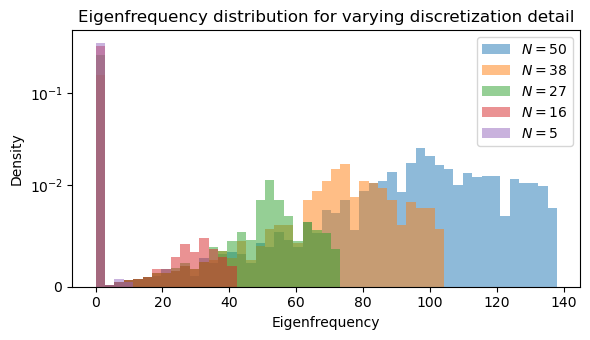

In [ ]:
min_eigfreq = np.min(eigfreqs)
max_eigfreq = np.max(eigfreqs)
N_bins = 50
bin_edges = np.linspace(min_eigfreq, max_eigfreq, N_bins)

plt.figure(figsize=(6, 3.5), layout='tight')

for n in np.linspace(0, len(Nxs)-1, 5, dtype=int)[::-1]:
    plt.hist(eigfreqs[n, :], bins=bin_edges, density=True, alpha=0.5, label=f'$N={Nxs[n]}$')

plt.xlabel('Eigenfrequency')
plt.ylabel('Density')
plt.yscale('symlog', linthresh=1e-2)
plt.legend(loc='upper right')
plt.title('Eigenfrequency distribution for varying discretization detail')
plt.savefig(f'{MEDIA_PATH}/eigfreqs_distribution_comparison_discretization.png')